In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from random import *
from sklearn.cluster import KMeans
from datetime import datetime

# Transforming data to DateTime and resample

In [ ]:
d = []
for i in range(10):
    d.append(randint(1, 15226)) 
d

In [3]:
#list of prices
prices_str = ['C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/6176.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/13214.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/13619.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/823.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/9132.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/8232.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/12711.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/8501.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/12297.csv',
             'C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/5789.csv']

In [15]:
def all_prices():
    prices = pd.read_csv(prices_str[0], header = None, delimiter = ';', index_col=0, names = str(0))
    for i in range(1,len(prices_str)):
        temp = pd.read_csv(prices_str[i], header = None, delimiter = ';', index_col=0, names = str(i))
        prices = prices.append(temp)
    index = pd.DatetimeIndex(prices.index)
    prices.set_index(index, inplace = True)
    prices = prices.resample('H').mean()
    return prices

In [18]:
def create_model(x,i):
    m = Prophet(yearly_seasonality=True)
    print('ts {} is being fit'.format(i))
    m.fit(x)
    f = m.predict(x)
    return f

In [19]:
def predicts(prices):
    filled_prices = pd.DataFrame(index = prices.index)
    for i in range(len(prices.columns)):
        renamed = pd.DataFrame(data = prices[str(i)], index = prices.index)
        renamed.reset_index(inplace = True)
        renamed.rename(columns = {'index': 'ds', str(i): 'y'}, inplace = True)
        filled_prices = filled_prices.assign(x = create_model(renamed,i)['yhat'].values)
        filled_prices.rename(columns = {'x': str(i)}, inplace = True)
    return filled_prices

In [20]:
bdays = predicts(all_prices().loc[all_prices().index.dayofweek < 5]['2016':'2017'])

ts 0 is being fit
ts 1 is being fit
ts 2 is being fit
ts 3 is being fit
ts 4 is being fit
ts 5 is being fit
ts 6 is being fit
ts 7 is being fit
ts 8 is being fit
ts 9 is being fit


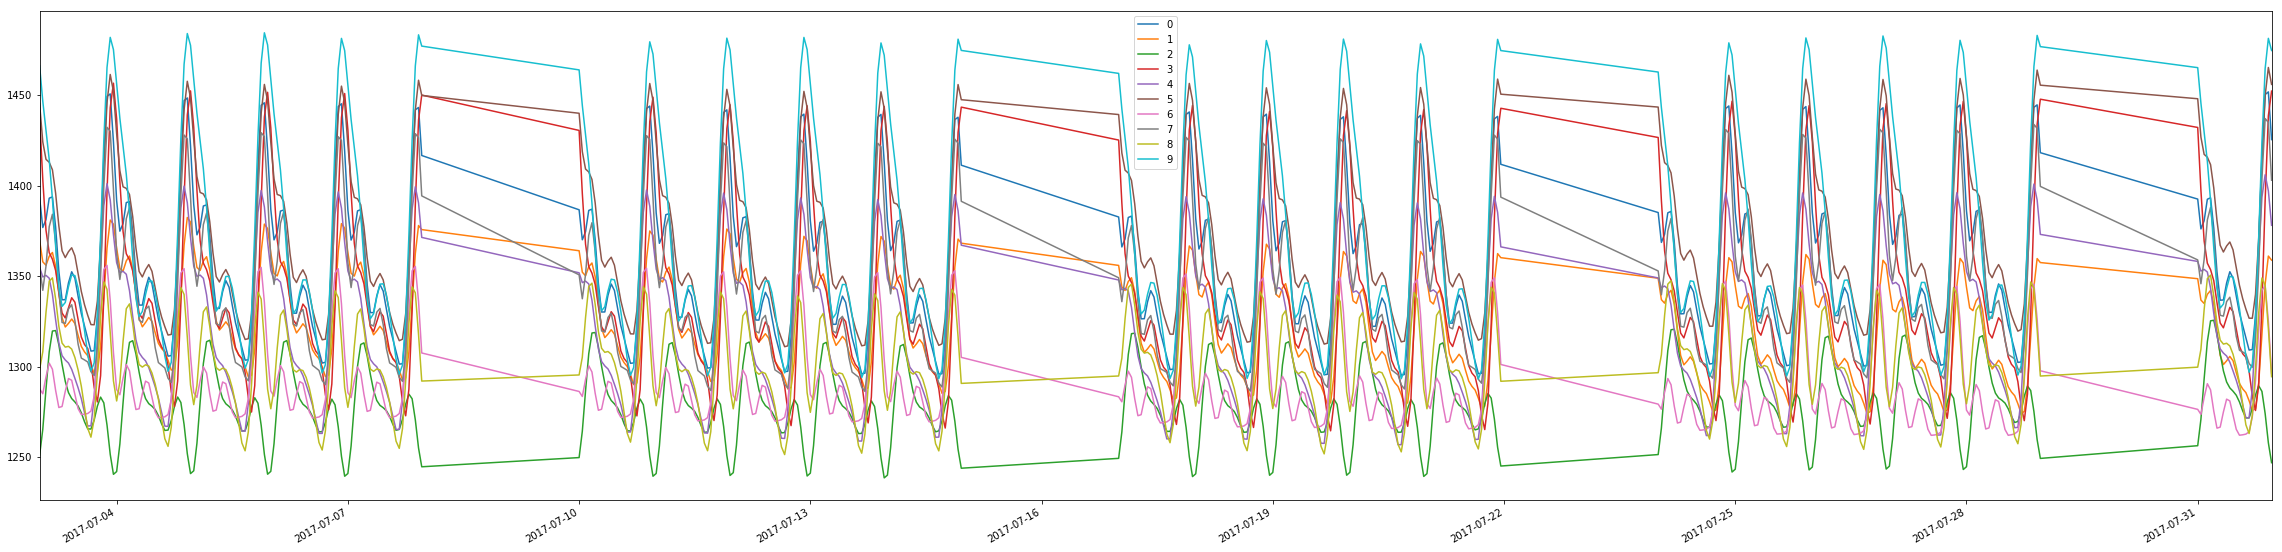

In [28]:
bdays['2017-07'].plot(figsize = (40,10))
plt.show()

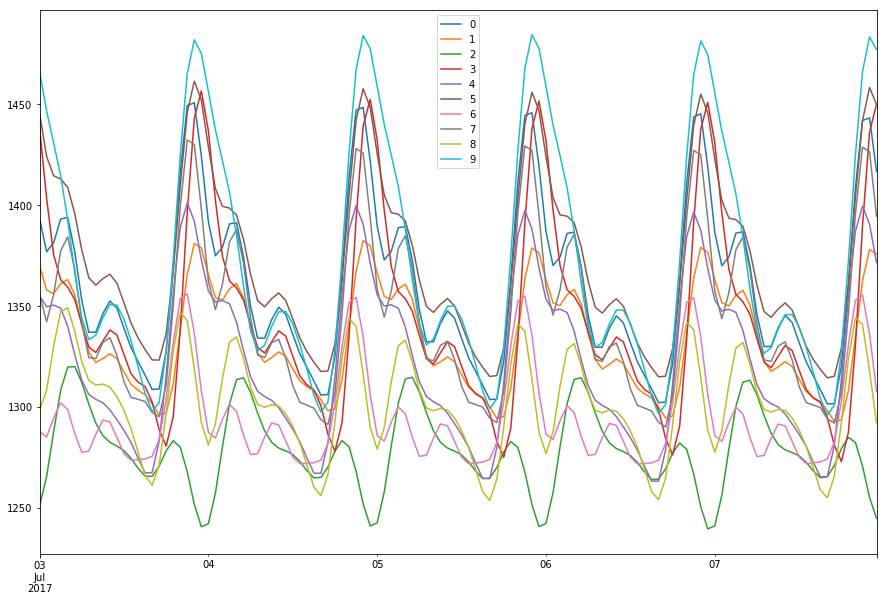

In [29]:
bdays['2017-07-03':'2017-07-07'].plot(figsize = (15,10))
plt.show()

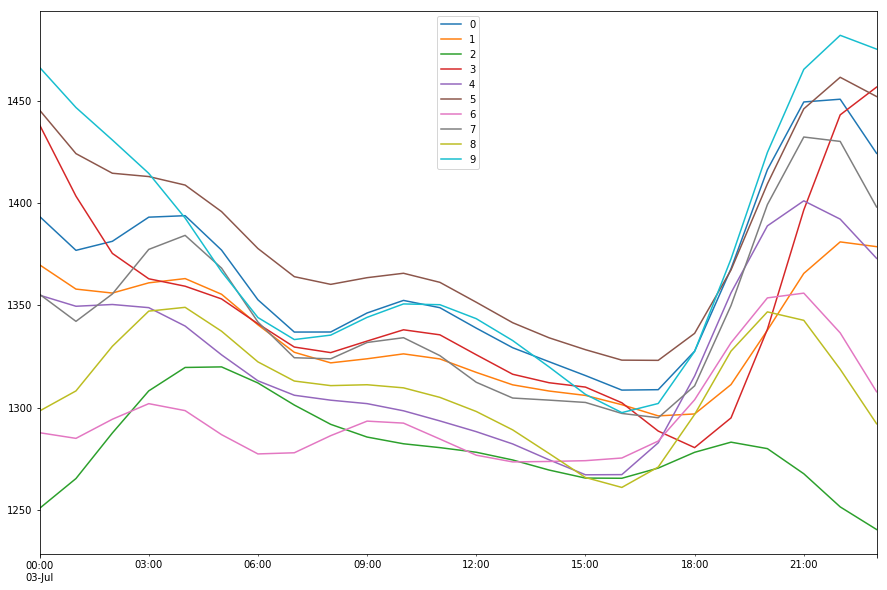

In [31]:
bdays['2017-07-03'].plot(figsize = (15,10))
plt.show()

In [25]:
filled_prices.head()

,0,1,2,3,4,5,6,7,8,9
2016-01-01 04:00:00,1369.980386,1286.499217,1275.840753,1295.496147,1303.698483,1329.490738,1262.162041,1349.888637,1285.123056,1343.182950
2016-01-01 05:00:00,1355.132412,1279.945304,1276.842844,1289.695037,1289.613112,1318.253614,1251.350662,1335.827915,1275.163717,1320.725010
2016-01-01 06:00:00,1331.738926,1265.837794,1270.104783,1277.176071,1276.125427,1300.852492,1241.125099,1309.823426,1261.811954,1298.674840
2016-01-01 07:00:00,1315.795710,1252.812705,1260.014320,1265.037786,1268.087538,1287.734253,1240.234061,1291.409987,1253.533073,1286.025255
2016-01-01 08:00:00,1315.295141,1247.704970,1250.974904,1261.673216,1265.080687,1285.208950,1247.802432,1289.666472,1251.848066,1285.913879


In [9]:
filled_prices1 = filled_prices['2016-08']

# feature based clustering (local min/max number, overall min)

In [10]:
#local minimas
def l_minimas(a):
    y = np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]
    return y

In [11]:
#local maximas
def l_maximas(a):
    y = np.r_[True, a[1:] > a[:-1]] & np.r_[a[:-1] > a[1:], True]
    return y

In [12]:
#smooth the ts using convolve 
def smooth(x, window_len):
    z = np.ones(window_len)/window_len
    y = np.convolve(x, z, mode = 'same')
    return y

In [ ]:
#print(l_minimas(smooth(filled_prices['8'].values, 24)))

In [68]:
#minimas['0'][minimas.index == datetime.strptime('2016-01-01', "%Y-%m-%d").date()] = 1

In [115]:
#number of local minimas in every ts
#window of 24 because 24 hours? smooth(filled_prices[str(i)].values, 24)
minimas = []
for i in range(10):
    for j in np.unique(filled_prices1.index.date):
        tmp = []
        tmp.append(np.count_nonzero(l_minimas(filled_prices1[str(i)][filled_prices1.index.date == j].values)))
    minimas.append(np.mean(tmp))
print(np.unique(minimas))

[ 2.  3.  4.]


In [44]:
#number of local maximas in every ts
#window of 24 because 24 hours? 
maximas = []
for i in range(10):
    for j in np.unique(filled_prices1.index.date):
        tmp = []
        tmp.append(np.count_nonzero(l_maximas(filled_prices1[str(i)][filled_prices1.index.date == j].values)))
    maximas.append(np.mean(tmp))
print(maximas)

[4.0, 4.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0]


In [113]:
#overall minimum
ov_min = []
for i in range(10):
    for j in np.unique(filled_prices1.index.date):
        tmp = []
        tmp.append(np.min(filled_prices1[str(i)][filled_prices1.index.date == j].values))
    ov_min.append(np.mean(tmp))
print(ov_min)

[1293.8033960260082, 1275.0458967830782, 1248.9486945972903, 1245.4586323738617, 1265.4233442127563, 1276.6971230259003, 1266.8090831277345, 1255.5635536686798, 1255.3381706608645, 1272.6161271147307]


In [ ]:
#target for clustering: over mean below mean 
target = []
for i in range(len(filled_prices1.index.date)):
    if filled_prices1['0']

In [63]:
results = pd.DataFrame({'num_local_min': minimas, 
                      'num_local_max': maximas, 
                      'overall_min': ov_min})


In [99]:
results

,num_local_max,num_local_min,overall_min,group
0,4.0,4.0,1293.803396,1
1,4.0,4.0,1275.045897,1
2,2.0,3.0,1248.948695,0
3,3.0,2.0,1245.458632,0
4,3.0,3.0,1265.423344,0
5,4.0,4.0,1276.697123,1
6,4.0,4.0,1266.809083,1
7,4.0,4.0,1255.563554,0
8,3.0,4.0,1255.338171,0
9,3.0,3.0,1272.616127,1


In [96]:
g = []
for i in range(len(results)):
    if results.iloc[i]['overall_min'] > results['overall_min'].mean():
        g.append(1)
    else: 
        g.append(0)

In [98]:
results['group'] = g

In [122]:
estimator = KMeans(n_clusters=2, n_init=9)
estimator.fit(results.drop('group', axis = 1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=9, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [123]:
results['clusters'] = estimator.labels_

In [124]:
results

,num_local_max,num_local_min,overall_min,group,clusters
0,4.0,4.0,1293.803396,1,0
1,4.0,4.0,1275.045897,1,0
2,2.0,3.0,1248.948695,0,1
3,3.0,2.0,1245.458632,0,1
4,3.0,3.0,1265.423344,0,0
5,4.0,4.0,1276.697123,1,0
6,4.0,4.0,1266.809083,1,0
7,4.0,4.0,1255.563554,0,1
8,3.0,4.0,1255.338171,0,1
9,3.0,3.0,1272.616127,1,0


In [101]:
#number of local maximas in every ts
#window of 24 because 24 hours? 
maximas = []
    for i in range(10):
        tmp.append(np.count_nonzero(l_maximas(filled_prices[str(i)].values)))
        minimas.append(np.mean(tmp))
print(maximas)
#np.mean(maximas)

IndentationError: unexpected indent (<ipython-input-101-73d7c4b79275>, line 4)

In [220]:
#overall maximum
ov_max = []
for j in np.unique(filled_prices1.index.date):
    for i in range(10):
        ov_max.append(np.max(filled_prices1[str(i)][filled_prices1.index.date == j].values))
print(len(ov_max))

310


In [221]:
#overall mean
ov_mean = []
for j in np.unique(filled_prices1.index.date):
    for i in range(10):
        ov_mean.append(np.mean(filled_prices1[str(i)][filled_prices1.index.date == j].values))
print(len(ov_mean))

310


In [41]:
#hour in which overall minimum accured
ov_min_hour = []
for i in range(10):
    for j in np.unique(filled_prices1.index.date):
        tmp = []
        tmp.append(filled_prices1.index.hour[filled_prices1[str(i)][filled_prices1.index.date == j].values == np.min(filled_prices1[str(i)][filled_prices1.index.date == j].values)])
        print(tmp)
print(ov_min_hour)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 744 but corresponding boolean dimension is 24

In [2]:
fuelPrice = pd.read_csv('C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/1.csv', header = None, delimiter = ';', names = ('Time', 'Price'))
index = pd.DatetimeIndex(fuelPrice.Time)
fuelPrice.drop('Time', axis = 1, inplace = True)
fuelPrice.set_index(index, inplace = True)
fuelPrice = fuelPrice['2016':'2017']
fuelPrice = fuelPrice[fuelPrice.index.dayofweek < 5]
fuelPrice = fuelPrice.resample('H').mean()
fuelPrice.dropna(inplace = True)
fuelPrice.reset_index(inplace = True)